# Preprocessing

## Import 

In [1]:
from pathlib import Path
import os
import random
import shutil

import pandas as pd
from PIL import Image, ImageEnhance

In [2]:
# Update this path to your extracted dataset directory
DATA_ROOT = Path("/home/a110101162/ai_cup/dataset")  

# Data Structures:
# DATA_ROOT /
#   Training Dataset /
#       training_image / patient0001 ... patient0050
#       training_label / patient0001 ... patient0050
train_image_root = DATA_ROOT / "training_image"
train_label_root = DATA_ROOT / "training_label"

print(train_image_root)
print(train_label_root)

/home/a110101162/ai_cup/dataset/training_image
/home/a110101162/ai_cup/dataset/training_label


## Index Training Images and Labels
Traverse the dataset to catalog every image, label path, and label availability.


In [3]:
rows = []

# Traverse each patient folder
for patient_dir in sorted(train_image_root.iterdir()):
    if not patient_dir.is_dir():
        continue
    patient_id = patient_dir.name  # e.g. 'patient0001'
    
    image_dir = train_image_root / patient_id
    label_dir = train_label_root / patient_id
    
    # Iterate through each patient's PNG images
    for img_path in sorted(image_dir.glob("*.png")):
        stem = img_path.stem  # e.g. 'patient0001_0201'
        label_path = label_dir / f"{stem}.txt"
        has_label = label_path.exists()
        
        rows.append({
            "patient": patient_id,
            "image_path": str(img_path),
            "label_path": str(label_path) if has_label else None,
            "has_label": has_label,
        })

df = pd.DataFrame(rows)
df.head()

,patient,image_path,label_path,has_label
0,patient0001,/home/a110101162/ai_cup/dataset/training_image...,None,False
1,patient0001,/home/a110101162/ai_cup/dataset/training_image...,None,False
2,patient0001,/home/a110101162/ai_cup/dataset/training_image...,None,False
3,patient0001,/home/a110101162/ai_cup/dataset/training_image...,None,False
4,patient0001,/home/a110101162/ai_cup/dataset/training_image...,None,False


In [4]:
## Summarize Label Coverage
summary = df.groupby("patient")["has_label"].agg(
    total_images="count",
    labeled_images="sum"
)
summary["unlabeled_images"] = summary["total_images"] - summary["labeled_images"]
summary.head()

,total_images,labeled_images,unlabeled_images
patient,,,
patient0001,341,50,291
patient0002,391,65,326
patient0003,324,70,254
patient0004,365,71,294
patient0005,285,54,231


## Split Patients Into Train and Validation Sets


In [5]:
# Shuffle patient IDs once for a reproducible partition and mark each row accordingly.
random.seed(42)  # for reproducibility

patients = sorted(df["patient"].unique())
print("Total patients:", len(patients))

random.shuffle(patients)
val_patients = patients[:10]   # Use 10 patients for validation
train_patients = patients[10:] # Use the remaining patients for training

print("Train patients:", len(train_patients))
print("Val patients:", len(val_patients))

Total patients: 50
Train patients: 40
Val patients: 10


In [6]:
def assign_split(patient_id):
    if patient_id in val_patients:
        return "val"
    else:
        return "train"

df["split"] = df["patient"].apply(assign_split)
df["split"].value_counts()
df.groupby(["split", "has_label"])["image_path"].count()

split  has_label
train  False        11334
       True          2239
val    False         2742
       True           548
Name: image_path, dtype: int64

## Prepare YOLO Directory Structure

In [7]:
yolo_root = DATA_ROOT / "yolo_dataset"
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    (yolo_root / sub).mkdir(parents=True, exist_ok=True)

yolo_root

PosixPath('/home/a110101162/ai_cup/dataset/yolo_dataset')

In [8]:
# Copy Images and Labels
for _, row in df.iterrows():
    split = row["split"]  # 'train' or 'val'
    img_src = Path(row["image_path"])
    img_dst = yolo_root / "images" / split / img_src.name
    
    # Copy the image file
    if not img_dst.exists():
        shutil.copy2(img_src, img_dst)
    
    # Handle the label file
    label_dst = yolo_root / "labels" / split / f"{img_src.stem}.txt"
    if row["has_label"]:
        label_src = Path(row["label_path"])
        if not label_dst.exists():
            shutil.copy2(label_src, label_dst)
    else:
        # Create an empty label file to mark images without an aortic valve
        if not label_dst.exists():
            open(label_dst, "w").close()

print("Copy done.")

Copy done.


In [9]:
## Sanity-Check File Counts
for split in ["train", "val"]:
    n_img = len(list((yolo_root / "images" / split).glob("*.png")))
    n_lbl = len(list((yolo_root / "labels" / split).glob("*.txt")))
    print(split, "images:", n_img, "labels:", n_lbl)

train images: 13573 labels: 13573
val images: 3290 labels: 3290


## Data augmentation

In [10]:
# Oversampling multiplier; adjust as needed:
OVERSAMPLE_FACTOR = 2  # Duplicate each labeled training image twice

train_df = df[(df["split"] == "train") & (df["has_label"])]

len(train_df)

2239

In [11]:
random.seed(42)

for _, row in train_df.iterrows():
    img_src = Path(row["image_path"])
    label_src = Path(row["label_path"])
    
    for k in range(OVERSAMPLE_FACTOR):
        # Generate a new filename such as patient0001_0201_dup0.png
        new_stem = f"{img_src.stem}_dup{k}"
        img_dst = yolo_root / "images" / "train" / f"{new_stem}.png"
        label_dst = yolo_root / "labels" / "train" / f"{new_stem}.txt"
        
        # Skip if the duplicate already exists to avoid unlimited growth
        if img_dst.exists():
            continue
        
        shutil.copy2(img_src, img_dst)
        shutil.copy2(label_src, label_dst)

print("Oversample done.")

Oversample done.


In [12]:
n_train_img = len(list((yolo_root / "images" / "train").glob("*.png")))
n_train_lbl = len(list((yolo_root / "labels" / "train").glob("*.txt")))
print("TRAIN images:", n_train_img, "labels:", n_train_lbl)

TRAIN images: 18051 labels: 18051


In [13]:
# Number of augmented versions per labeled training image
AUG_PER_IMAGE = 1  

random.seed(123)

train_df = df[(df["split"] == "train") & (df["has_label"])]

for _, row in train_df.iterrows():
    img_src = Path(row["image_path"])
    label_src = Path(row["label_path"])
    
    # Open the image with PIL and convert to RGB (three channels for YOLO)
    img = Image.open(img_src).convert("RGB")
    
    for k in range(AUG_PER_IMAGE):
        # Randomly choose brightness or contrast
        if random.random() < 0.5:
            enhancer = ImageEnhance.Brightness(img)
            factor = random.uniform(0.7, 1.3)  # Brightness scale
        else:
            enhancer = ImageEnhance.Contrast(img)
            factor = random.uniform(0.7, 1.3)  # Contrast scale
        
        img_aug = enhancer.enhance(factor)
        
        new_stem = f"{img_src.stem}_aug{k}"
        img_dst = yolo_root / "images" / "train" / f"{new_stem}.png"
        label_dst = yolo_root / "labels" / "train" / f"{new_stem}.txt"
        
        if img_dst.exists():
            continue
        
        img_aug.save(img_dst)
        shutil.copy2(label_src, label_dst)

print("Augmentation done.")

Augmentation done.


In [14]:
n_train_img = len(list((yolo_root / "images" / "train").glob("*.png")))
n_train_lbl = len(list((yolo_root / "labels" / "train").glob("*.txt")))
print("TRAIN images (after aug):", n_train_img, "labels:", n_train_lbl)

TRAIN images (after aug): 20290 labels: 20290


## Visual Inspection
Plot a random training slice with its bounding boxes as a sanity check.


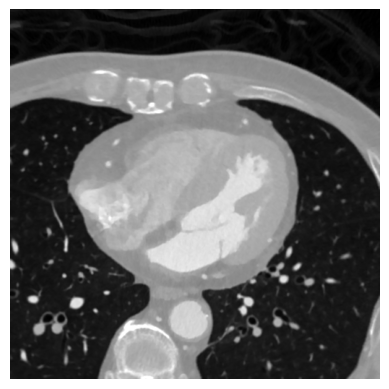

In [15]:
import matplotlib.pyplot as plt

def show_sample(image_path, label_path):
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    
    # Read every bounding box (potentially multiple per image)
    boxes = []
    if Path(label_path).exists():
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                _, xc, yc, bw, bh = map(float, parts)
                x_min = (xc - bw/2) * w
                x_max = (xc + bw/2) * w
                y_min = (yc - bh/2) * h
                y_max = (yc + bh/2) * h
                boxes.append((x_min, y_min, x_max, y_max))
    
    plt.imshow(img, cmap="gray")
    ax = plt.gca()
    for (x1, y1, x2, y2) in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             fill=False, linewidth=2)
        ax.add_patch(rect)
    plt.axis("off")
    plt.show()

# Inspect a random sample
sample_img = next((yolo_root / "images" / "train").glob("*.png"))
sample_label = yolo_root / "labels" / "train" / (sample_img.stem + ".txt")
show_sample(sample_img, sample_label)

# YOLO Training

In [16]:
import os
os.chdir("/home/a110101162/ai_cup/dino-yolo")

In [18]:
from pathlib import Path

# Path to your YOLO dataset directory
YOLO_DATA_ROOT = Path("/home/a110101162/ai_cup/dataset/yolo_dataset").resolve()

yaml_text = f"""
path: {YOLO_DATA_ROOT}
train: images/train
val: images/val

nc: 1
names: ["aortic_valve"]
"""

with open("aortic_valve.yaml", "w", encoding="utf-8") as f:
    f.write(yaml_text)

print((Path.cwd() / "aortic_valve.yaml").read_text())


path: /home/a110101162/ai_cup/dataset/yolo_dataset
train: images/train
val: images/val

nc: 1
names: ["aortic_valve"]



In [ ]:
!python train_yolov12_dino.py \
    --data aortic_valve.yaml \
    --yolo-size s \
    --epochs 100 \
    --imgsz 512 \
    --batch-size 8 \
    --name av_yolov12s_pure

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
🚀 YOLOv12 + DINOv3 Systematic Training Script
🚀 Pure YOLOv12 Mode: No DINO enhancement
Auto-determined AMP: True (enabled for pure YOLO)
✅ Validation enabled - YOLO will verify data availability during initialization
📊 Training Configuration:
   Model: YOLOv12s
   DINO: None (Base YOLOv12)
   Config: ultralytics/cfg/models/v12/yolov12.yaml
   Dataset: aortic_valve.yaml
   Validation: Enabled
   Epochs: 100
   Batch Size: 8
   Image Size: 512
   Device: 0
   Experiment: av_yolov12s_pure

🎛️  Hyperparameters:
   Learning Rate: 0.01 (final: 0.0001)
   Optimizer: SGD
   Weight Decay: 0.0005
   Momentum: 0.937
   Warmup: 3 epochs
   Label Smoothing: 0.0
   Mixed Precision: Enabled
   Fitness Weights: mAP@0.5=0.100, mAP@0.5:0.95=0.900

🎨 Data Augmentation:
   Scale: 0.9
   Mosaic: 1.0
   Mixup: 0.05
   Copy-Paste: 0.0
   HSV: H=0.015, S=0.7, V=0.4
   Geometric: degrees=0.0, translate=0.1, shear=0.0
  

# Predict Test Images
Instantiate a YOLO model from the saved best weights.

In [ ]:
from ultralytics import YOLO
from pathlib import Path

best_weights = Path("runs/detect/av_yolov12s_pure/weights/best.pt")
model = YOLO(str(best_weights))

In [ ]:
DATA_ROOT = Path("/home/a110101162/ai_cup/dataset")  # Update this to your actual data root

test_image_root = DATA_ROOT / "testing_image"
print(test_image_root)

In [ ]:
test_images = sorted(test_image_root.glob("patient*/**/*.png"))
len(test_images)

# Build Submission

In [ ]:
submission_lines = []

for img_path in test_images:
    # Image name without the .png suffix, such as patient0051_0201
    stem = img_path.stem
    
    # Run inference with verbose mode disabled for cleaner logs
    results = model.predict(
        source=str(img_path),
        imgsz=512,
        conf=0.05,   # Adjust the confidence threshold as needed; 0.05 keeps more boxes
        iou=0.7,
        verbose=False
    )
    
    r = results[0]
    boxes = r.boxes.xyxy.cpu().numpy()   # shape: [N,4]
    scores = r.boxes.conf.cpu().numpy()  # shape: [N]
    classes = r.boxes.cls.cpu().numpy()  # shape: [N]
    
    # Skip lines when no predictions exist for an image per competition rules
    if len(boxes) == 0:
        continue
    
    for (x1, y1, x2, y2), score, cls_id in zip(boxes, scores, classes):
        # There is only one class, so cls_id should always be 0
        # Cast coordinates to integers as requested in the briefing
        line = f"{stem} {int(cls_id)} {float(score):.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}"
        submission_lines.append(line)

In [ ]:
submission_path = Path("submission_av_yolov12s_pure.txt")
with open(submission_path, "w") as f:
    for line in submission_lines:
        f.write(line + "\n")

print("Saved submission file to:", submission_path.resolve())
print("Total predictions:", len(submission_lines))